In [ ]:
#Importing necessary dependancies
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model ,Sequential
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D,MaxPooling2D, concatenate, Dense, Flatten, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet50
#model.trainable = False  

* * * Loading data 

In [ ]:
#Loading the black and white mask images
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
#Loading the brain images
image_files = [file.replace('_mask', '') for file in mask_files]

**Assembling MRI scans with the corresponding masks**

First of all, there can be two category of images,one with tumor detected via the mask and the other with no tumor detected.
For MRI scans with a tumor detected, we are labeling them with 1,otherwise 0.

In [ ]:
#Defining the function for labeling the masks
def mask_labelizer(mask_image):
    mask_image=cv2.imread(mask_image)
    label=np.max(mask_image)
    if(label>0):
        label=1
    else:
        label=0
    return label
#Assembling the MRI scans with their corresponding masks into a dataframe
MRI_DATA = pd.DataFrame(
    {              "images": image_files,
                   "masks": mask_files,
                   "label":[
                       mask_labelizer(mask) for mask in mask_files #Using List Apprehension
                   ]}
)
#Displaying the dataframe
MRI_DATA.head()

**Looking at the MRI Scans with corresponding masks**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[20,20])
images,masks=[],[]

random_idc=[2,7,8,10,11,13,14,9]

for i in random_idc:
    images.append(np.array(cv2.imread(MRI_DATA['images'].iloc[i])))
    masks.append(np.array(cv2.imread(MRI_DATA['masks'].iloc[i])))

plt.subplot(2,2,1)
plt.imshow(images[0])
plt.subplot(2,2,2)
plt.imshow(masks[0])
plt.subplot(2,2,3)
plt.imshow(images[1])
plt.subplot(2,2,4)
plt.imshow(masks[1])


![Alt text](image.png)

**Splitting data into training and testing**

In [ ]:
from sklearn.model_selection import train_test_split
MRI_train,MRI_test=train_test_split(MRI_DATA,test_size=0.1,random_state=0)
MRI_test,MRI_val=train_test_split(MRI_test,test_size=0.5,random_state=0)
print('Shape of training data : {}\nShape of test data: {}\nShape of Validation data: {} '.format(len(MRI_train),len(MRI_test),len(MRI_val)))

![Alt text](image-1.png)

**Data Generator for Image Augmentation**

This is an important step to prevent overfitting and providing our model exposure to a variety of images

In [ ]:
'''Function for preprocessing images'''
#---------------------------------------------------------------------------------------------------------------------------------------------------------#
def preprocess_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    #Converting Masks into black and white images
    mask[mask>0.5]=1
    mask[mask<=0.5]=0
    return (img, mask)
#---------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for data augmentation'''
def image_augmentor(
       data_frame, batch_size,
        aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)#Data Generator for Images
    mask_datagen = ImageDataGenerator(**aug_dict) #Data Generator for Masks
    
   #----------------------------------------image augmentation for MRI scans-------------------------------------------------------------------------------
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "images",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
   #-----------------------------------------------------image augmentation for masks-----------------------------------------------------------------------

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "masks",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
  #--------------------------------------------------------------------------------------------------------------------------------------------------------
    train_augmentor = zip(image_generator, mask_generator)
    
    for (image, mask) in train_augmentor:
        image, mask = preprocess_data(image, mask)
        yield (image,mask)

# **Model Architecture**

For image segmentation tasks,widely used models are of "U-net" architecture. These models have an encoder unit(contracting unit) followed by a decoder unit(expansive unit). The two units are connected by a bridge layer.Image is downscaled in the contracting layer and upsclaed by the expansive layer. Attention gates are used in the decoder. Also, ResNet layers(pretrained) have been used in the encoder.

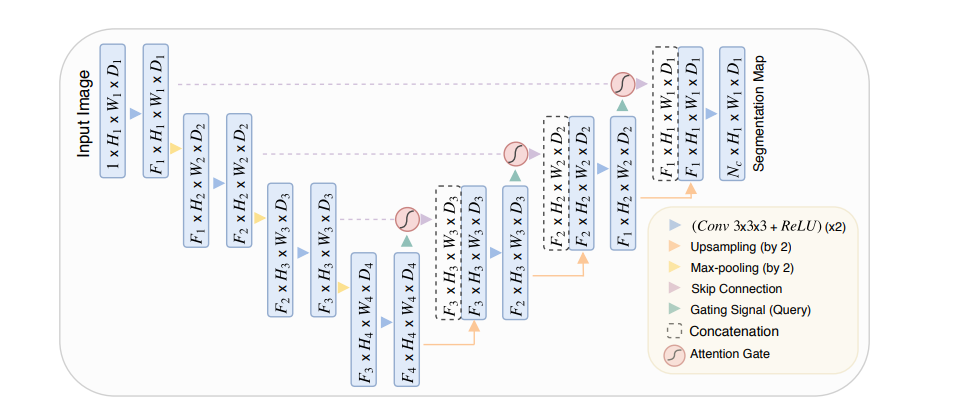![Res-U-Net-architecture-a-basic-block-of-the-

# Model Architecture- Code

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50


# #lambda function for repeating the result from AG
def repeat_elem(tensor, rep):
   
     return tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)



# Attention Gate


def attention_gate(g, s, num_filters):
    
    '''
    Attention Gate
    
    Inputs: 
        1.g: feature map from previous decoding layer
        2.s: corresponding skip connection from encoder
        
    Output:
        Attention map of the skip connection.
        
    '''
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s


# Convolution Block: Used in both encoder and decoder.

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
  
    
# Decoder Block

def decoder_block(x, s, num_filters,attention=True):
    '''
    Input:
        1. x : Previous decoder layer output
        2. s : Corresponding layer from encoder (skip-connection)
        3. attention: True 
        
    '''
    if attention==True:
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(x)
        s = attention_gate(x, s, num_filters)
        x = Concatenate()([x, s])
        x = conv_block(x, num_filters)
        return x
    elif attention=='else':
        x=Conv2DTranspose(num_filters,(2,2),strides=2,padding='same')(x)
        s=s[:,:,:,:-1]
        s=repeat_elem(s,rep=32)
        s=attention_gate(x,s,num_filters)
        x=Concatenate()([x,s])
        x=conv_block(x,num_filters)
        
        return x
    else:
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(x)

        s = repeat_elem(s,rep=2)

        s = attention_gate(x, s, num_filters)
        x = Concatenate()([x, s])
        x = conv_block(x, num_filters)
        
        return x
        

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ Encoder """
    s1 = resnet50.get_layer(index=0).output ## (256 x 256x3)
    s2 = resnet50.get_layer("conv1_relu").output ## (128 x 128)
    s3 = resnet50.get_layer("conv2_block3_out").output ## (64 x 64)
    s4 = resnet50.get_layer("conv3_block4_out").output ## (32 x 32)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output ## (32 x 32)

    """ Decoder """
    print("d1")
    d1 = decoder_block(b1, s4, 512) ## (32 x32)
    print("d2")
    d2 = decoder_block(d1, s3, 256) ## (64 x 64)
    print("d3")
    d3 = decoder_block(d2, s2, 128,attention=False) ## (128 x 128)
    print("d4")
    d4 = decoder_block(d3, s1, 64,attention='else') ## (256 x 256)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")

    return model

input_shape = (256,256, 3)
model = build_resnet50_unet(input_shape)
model.summary()

![Alt text](image-13.png)
![Alt text](image-14.png)

# Loss Function and Metrics

In [ ]:
smooth=1.
#-----------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for returning dice coefficient'''
def DICE_COEFF(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Dice Coefficient Loss'''
def dice_coef_loss(y_true, y_pred):
    return 1 - DICE_COEFF(y_true, y_pred)

#----------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for combining binary cross entropy with dice coeffcients for loss function'''
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

#----------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Function for Jacards coefficient'''
def IOU_JACARD(y_true, y_pred):
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    sum_jac = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_jac - intersection + smooth)
    return jac

In [ ]:
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 1e-4
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_generator = image_augmentor(MRI_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(256,256))
    
validation_generator = image_augmentor(MRI_val, BATCH_SIZE,
                                dict(),
                                target_size=(256,256))

In [ ]:
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, epsilon=None, amsgrad=False)

callbacks = [ModelCheckpoint('MRI_Attention_UNet_ResNet.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=12)]
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[IOU_JACARD, DICE_COEFF])

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(MRI_train) // 16, 
                    epochs=100, 
                    callbacks=callbacks,
                    validation_data = validation_generator,
                    validation_steps=len(MRI_val) // 16)

![Alt text](image-4.png)

![Alt text](image-5.png)

###### 

In [ ]:
model.save('Segmentation_MRI_BRAIN_Attention_ResNet_Encoded_Model_FINAL.h5')

In [ ]:
test_gen = image_augmentor(MRI_test, BATCH_SIZE,
                                dict(),
                                target_size=(256,256))
results = model.evaluate(test_gen, steps=len(MRI_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

![Alt text](image-6.png)

**Predictions**

In [ ]:
for i in range(50):
    #------------------------------------------------------------------------------------------------------------------------------------------------------#
    index=np.random.randint(1,len(MRI_test.index))
    img = cv2.imread(MRI_test['images'].iloc[index])
    img = cv2.resize(img ,(256,256))
    img = img / 255
    img = img[np.newaxis, :, :, :]#Increasing the dimensions for predictions
    pred=model.predict(img)
    #------------------------------------------------------------------------------------------------------------------------------------------------------#
    plt.figure(figsize=(20,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(MRI_test['masks'].iloc[index]))) #Reducing dimensions
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

![Alt text](image-7.png)
![Alt text](image-8.png)
![Alt text](image-9.png)
![Alt text](image-10.png)
![Alt text](image-11.png)
![Alt text](image-12.png)